# Independent Wishart process regression

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '1'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [1]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import os
import sys

from blackjax import normal_random_walk
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from jaxtyping import Array

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, smc_inference_loop, elliptical_slice_nd

from bamojax.more_distributions import GaussianProcessFactory, RBF, Zero

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


BaMoJax imports:

## The independent Wishart process

The independent Wishart process is an extension of the generalised Wishart process. Rather than having a single, shared, set of covariance function hyperparameters, in the IWP we have $D$ sets of these (where $D$ is the number of time series, such that $\Sigma(t) \in \mathbb{R}^{D\times D}$). This, in theory, allows the model much more flexibility, but will of course be harder to estimate.

**TODO**: Set up proper test case.

In [ ]:
def independent_wishart_transformation(F: Array, L: Array = None, L_vec = None) -> Array:
    r""" Transformes an array of (d, nu, n) Gaussian process draws into an array of (n, d, d) Wishart-distributed covariance matrices.

    Formally, we have

    \Sigma(t) = \sum_{j=1}^\nu L F(t)_j F(t)^T_j L^T.

    It follows from the construction (with GP output variance 1.0) that \Sigma(t) ~ W_d(V, nu), with V the Wishart location and nu its degrees of freedom.

    Args:
        F: An array of size (d, nu, n), with d the number of variables, nu>d the degrees-of-freedom and n the number of timepoints. F[i,j,:] ~ GP(mean, cov_fn)
        L: The Cholesky decomposition of the Wishart location matrix V
        L_vec: The transformed matrix vec(L) for easier sampling.
    Returns:
        LFFL: An array of size (n, d, d)

    """

    d = F.shape[0]
    F = jnp.transpose(F, axes=[2, 1, 0])

    def vec2tril(v):
        L_sample = jnp.zeros((d, d))
        return L_sample.at[jnp.tril_indices(d, 0)].set(v)

    #
    def outer_self_sum(x):
        def outer_self(x_):
            return jnp.outer(x_, x_)
        return jnp.sum(jax.vmap(outer_self, in_axes=(0))(x), axis=0)

    #
    if L is None and L_vec is not None:
        L = vec2tril(L_vec)

    FF = jax.vmap(outer_self_sum, in_axes=(0))(F)
    
    LFFL = jax.vmap(jnp.matmul,
                    in_axes=(0, None))(jax.vmap(jnp.matmul,
                                                in_axes=(None, 0))(L, FF), L.T)
    
    return LFFL
 
#
def independent_wishart_link_fn(F: Array, shape: tuple, L: Array = None, L_vec: Array = None) -> dict:
    r""" Transform the (F, L) or (F, vec(L)) representation of the Wishart process into a set of parameters for dx.MultivariateNormalFullCovariance ('loc and covariance_matrix')

    Args:
        F: The (d, nu) draws of a GP, f ~ GP(., .). If the collected f's are flattened, they are reshaped here.
        L / vec(L): The scale matrix of the Wishart distribution.
    Returns:
        A dictionary containing the arguments for a distrax MultivariateNormalFullCovariance distribution object.    
    
    """
    if jnp.ndim(F) < 3:
        F = jnp.reshape(F, shape=shape)
    d = shape[0]
    LFFL = independent_wishart_transformation(F=F, L=L, L_vec=L_vec)
    return dict(loc=jnp.zeros((d, )), covariance_matrix=LFFL)

#

Download timeseries for GWP example:

In [4]:
import numpy as np
import yfinance as yf

print('Download timeseries')
data = yf.download("^GDAXI ^GSPC", start="2017-09-10", end="2022-09-10", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()

Y = jnp.asarray(returns.iloc[0:-1:10, :])
time = returns.index[0:-1:10]

[*********************100%***********************]  2 of 2 completed

Download timeseries


Do we implement the sequence of parents as a list or dict or a new structure entirely?

SyntaxError: invalid syntax (2815615393.py, line 1)

In [ ]:
def independent_wishart_transformation(F: Array, L: Array = None, L_vec = None) -> Array:
    r""" Transformes an array of (d, nu, n) Gaussian process draws into an array of (n, d, d) Wishart-distributed covariance matrices.

    Formally, we have

    \Sigma(t) = \sum_{j=1}^\nu L F(t)_j F(t)^T_j L^T.

    It follows from the construction (with GP output variance 1.0) that \Sigma(t) ~ W_d(V, nu), with V the Wishart location and nu its degrees of freedom.

    Args:
        F: An array of size (d, nu, n), with d the number of variables, nu>d the degrees-of-freedom and n the number of timepoints. F[i,j,:] ~ GP(mean, cov_fn)
        L: The Cholesky decomposition of the Wishart location matrix V
        L_vec: The transformed matrix vec(L) for easier sampling.
    Returns:
        LFFL: An array of size (n, d, d)

    """

    d = F.shape[0]
    F = jnp.transpose(F, axes=[2, 1, 0])

    def vec2tril(v):
        L_sample = jnp.zeros((d, d))
        return L_sample.at[jnp.tril_indices(d, 0)].set(v)

    #
    def outer_self_sum(x):
        def outer_self(x_):
            return jnp.outer(x_, x_)
        return jnp.sum(jax.vmap(outer_self, in_axes=(0))(x), axis=0)

    #
    if L is None and L_vec is not None:
        L = vec2tril(L_vec)

    FF = jax.vmap(outer_self_sum, in_axes=(0))(F)
    
    LFFL = jax.vmap(jnp.matmul,
                    in_axes=(0, None))(jax.vmap(jnp.matmul,
                                                in_axes=(None, 0))(L, FF), L.T)
    
    return LFFL
 
#
def independent_wishart_link_fn(L_vec: Array, shape: tuple, L: Array = None, **Fkwargs) -> dict:
    r""" Transform the (F, L) or (F, vec(L)) representation of the Wishart process into a set of parameters for dx.MultivariateNormalFullCovariance ('loc and covariance_matrix')

    Args:
        F: The (d, nu) draws of a GP, f ~ GP(., .). If the collected f's are flattened, they are reshaped here.
        L / vec(L): The scale matrix of the Wishart distribution.
    Returns:
        A dictionary containing the arguments for a distrax MultivariateNormalFullCovariance distribution object.    
    
    """
    d = len(Fkwargs)
    Fs = []
    for i in range(d):
        Fi = Fkwargs[f'F_{i}']
        if jnp.ndim(Fi) < 2:
            Fi = jnp.reshape(Fi, shape=shape)
        Fs.append(Fi)
    F = jnp.stack(Fs)
    LFFL = independent_wishart_transformation(F=F, L=L, L_vec=L_vec)
    return dict(loc=jnp.zeros((d, )), covariance_matrix=LFFL)

#

n, d = Y.shape
nu = d + 1
m = int(d*(d+1)/2)
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

partial_wishart_link_fn = lambda L_vec, **Fkwargs: independent_wishart_link_fn(L_vec=L_vec, shape=(nu, n), **Fkwargs)

IWP = Model('Independent Wishart process')
x_node = IWP.add_node(name='input', observations=x)
Fs = []
for i in range(d):
    ls_node = IWP.add_node(name=f'lengthscale_{i}', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
    F_node = IWP.add_node(name=f'F_{i}', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=ls_node, 
                                    variance=1.0), shape=(nu, ))  # this probably isn't implemented correctly yet!
    Fs.append(F_node)
F_parents_dict = {fnode.name: fnode for fnode in Fs}
Lvec = IWP.add_node(name='L_vec', distribution=dx.Normal(loc=jnp.zeros((m, )), scale=jnp.ones((m, ))))
y_node = IWP.add_node(name='Y', 
                      distribution=dx.MultivariateNormalFullCovariance, 
                      parents=dict(L_vec=Lvec, **F_parents_dict), 
                      link_fn=partial_wishart_link_fn, 
                      observations=Y)

Set up Gibbs sampling within SMC for GWP (takes roughly 40 minutes):

In [ ]:
%%time

from bamojax.sampling import elliptical_slice_nd

step_fns = dict(lengthscale=normal_random_walk,
                L_vec=normal_random_walk)
step_fn_params = dict(lengthscale=dict(sigma=0.005),
                      L_vec=dict(sigma=0.001*jnp.eye(m)))

for i in range(d):
    F_key = f'F_{i}'
    step_fns[F_key] = elliptical_slice_nd
    step_fn_params[F_key] = dict(implied_mvn_prior=True, name='elliptical_slice_nd', nd=(nu, ))

gibbs = gibbs_sampler(IWP, step_fns=step_fns, step_fn_params=step_fn_params)

key = jrnd.PRNGKey(1234)
key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, IWP, kernel=gibbs, num_particles=1000, num_mcmc_steps=500)

for node in ['lengthscale_0', 'lengthscale_1', 'L_vec']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

Visualize model fit:

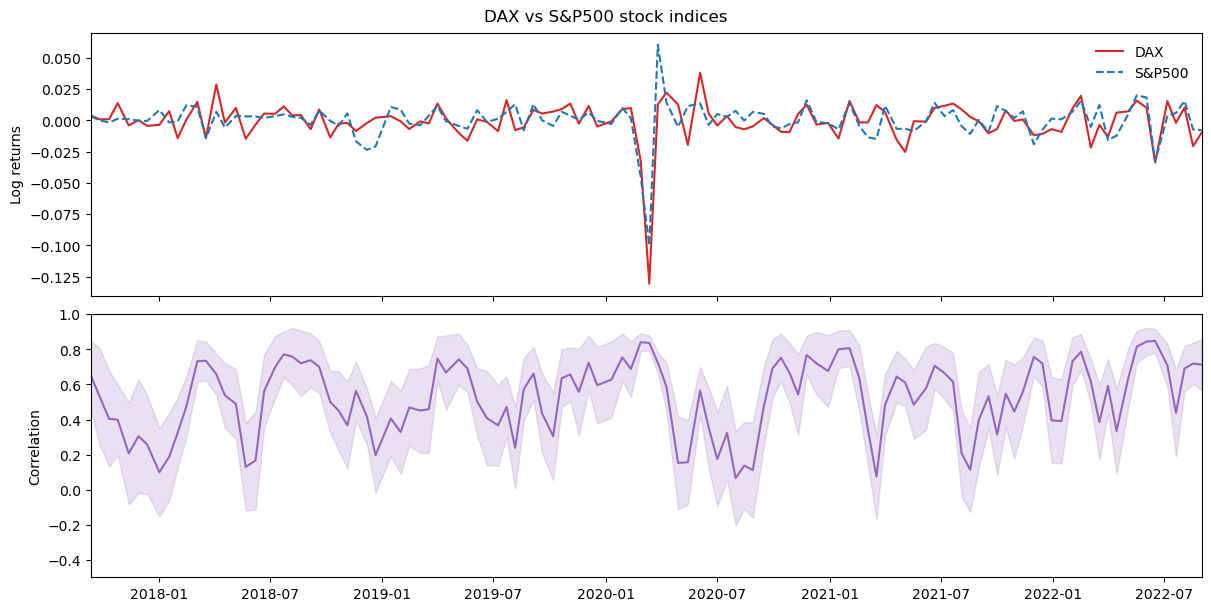

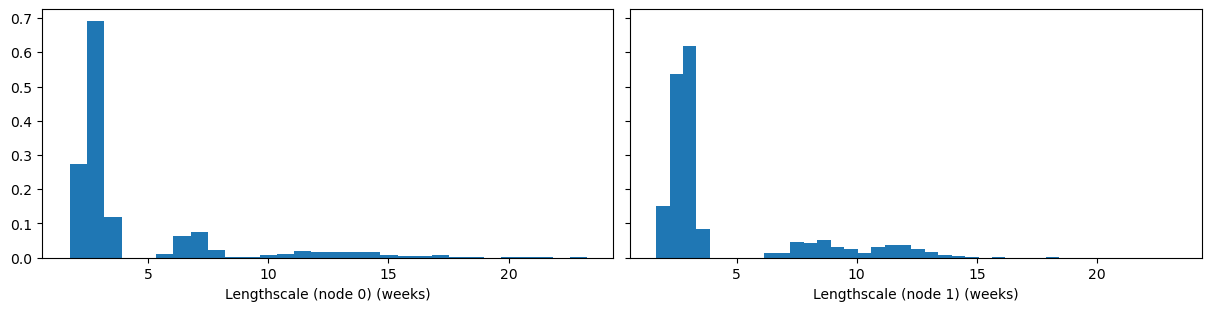

In [79]:
def cov2corr(Sigma):
    v = jnp.sqrt(jnp.diag(Sigma))
    outer_v = jnp.outer(v, v)
    correlation = Sigma / outer_v
    return correlation

#

def wrapper(particle):
    Lvec = particle['L_vec']
    Fs = []
    for i in range(d):
        Fi = particle[f'F_{i}']
        if jnp.ndim(Fi) < 2:
            Fi = jnp.reshape(Fi, shape=(nu, n))
        Fs.append(Fi)
    F = jnp.stack(Fs)
    LFFL = independent_wishart_transformation(F=F, L_vec=Lvec)
    return LFFL

#
    

LFFL_samples = jax.vmap(wrapper)(final_state.particles)
corr_samples = jax.vmap(jax.vmap(cov2corr, in_axes=0), in_axes=0)(LFFL_samples)

corr_mean = jnp.mean(corr_samples, axis=0)
corr_std = jnp.std(corr_samples, axis=0)

_, axes = plt.subplots(nrows=2, ncols=1, sharex=True, constrained_layout=True, figsize=(12, 6))
axes[0].plot(time, Y[:,0], label='DAX', color='tab:red')
axes[0].plot(time, Y[:,1], label='S&P500', color='tab:blue', ls='--')
axes[0].legend(frameon=False)
axes[0].set_ylabel('Log returns')
axes[1].plot(time, corr_mean[:, 0, 1], color='tab:purple')
axes[1].fill_between(time, corr_mean[:, 0, 1] - 0.5*corr_std[:, 0, 1], corr_mean[:, 0, 1] + 0.5*corr_std[:, 0, 1], color='tab:purple', alpha=0.2)
axes[1].set_ylabel('Correlation')
axes[1].set_ylim([-0.5, 1.0])
for ax in axes:
    ax.set_xlim([time[0], time[-1]])
plt.suptitle('DAX vs S&P500 stock indices')

_, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(12, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    ax.hist(final_state.particles[f'lengthscale_{i}']*(time[-1] - time[0]).days/7, bins=30, density=True)  # converted to years
    ax.set_xlabel(f'Lengthscale (node {i}) (weeks)')